In [27]:
import numpy as np 
import pandas as pd 
from matplotlib import cm, colors
import matplotlib.pyplot as plt 
import requests
from geopy.geocoders import Nominatim 
import folium
import json
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

In [2]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_page = requests.get(link)
df_CA = pd.read_html(wiki_page.content)[0]
df_CA = df_CA[df_CA['Borough'] != 'Not assigned']
df_CA.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [3]:
coords = pd.read_csv('https://cocl.us/Geospatial_data')
df_CA = df_CA.merge(coords, on='Postal Code')
df_CA.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [4]:
df_CA.groupby('Borough').count()

,Postal Code,Neighbourhood,Latitude,Longitude
Borough,,,,
Central Toronto,9,9,9,9
Downtown Toronto,19,19,19,19
East Toronto,5,5,5,5
East York,5,5,5,5
Etobicoke,12,12,12,12
Mississauga,1,1,1,1
North York,24,24,24,24
Scarborough,17,17,17,17
West Toronto,6,6,6,6


In [5]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [6]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_CA['Latitude'], df_CA['Longitude'], df_CA['Borough'], df_CA['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
toronto_venues = getNearbyVenues(names=df_CA['Neighbourhood'],
                                   latitudes=df_CA['Latitude'],
                                   longitudes=df_CA['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [10]:
print(toronto_venues.shape)
toronto_venues.head()

(2122, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [11]:
print(len(toronto_venues['Venue Category'].unique()))
toronto_venues['Venue Category'].unique()[:50]

275


array(['Park', 'Food & Drink Shop', 'Hockey Arena',
       'Portuguese Restaurant', 'Coffee Shop', 'French Restaurant',
       'Intersection', 'Pizza Place', 'Bakery', 'Distribution Center',
       'Breakfast Spot', 'Spa', 'Restaurant', 'Gym / Fitness Center',
       'Historic Site', 'Chocolate Shop', 'Farmers Market',
       'Dessert Shop', 'Pub', 'Performing Arts Venue', 'Event Space',
       'Yoga Studio', 'Café', 'Mexican Restaurant', 'Theater',
       'Shoe Store', 'Italian Restaurant', 'Brewery', 'Art Gallery',
       'Cosmetics Shop', 'Electronics Store', 'Beer Store', 'Bank',
       'Hotel', 'Health Food Store', 'Wine Shop', 'Antique Shop',
       'Boutique', 'Furniture / Home Store', 'Vietnamese Restaurant',
       'Clothing Store', 'Accessories Store', 'Gift Shop',
       'Miscellaneous Shop', 'Beer Bar', 'Creperie', 'Sushi Restaurant',
       'Diner', 'Hobby Shop', 'Burrito Place'], dtype=object)

In [12]:
toronto_dummy = pd.get_dummies(toronto_venues, columns=['Venue Category'])
toronto_dummy.drop(["Neighborhood Latitude", "Neighborhood Longitude", "Venue", "Venue Latitude", "Venue Longitude"], 
                   axis=1, inplace=True)
print(toronto_dummy.shape)
toronto_dummy.head()

(2122, 276)


,Neighbourhood,Venue Category_Accessories Store,Venue Category_Adult Boutique,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,...,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Video Game Store,Venue Category_Video Store,Venue Category_Vietnamese Restaurant,Venue Category_Warehouse Store,Venue Category_Wine Bar,Venue Category_Wine Shop,Venue Category_Wings Joint,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
toronto_cat = toronto_dummy.groupby('Neighbourhood').mean()
print(toronto_cat.shape)
toronto_cat.head()

(94, 275)


,Venue Category_Accessories Store,Venue Category_Adult Boutique,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,...,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Video Game Store,Venue Category_Video Store,Venue Category_Vietnamese Restaurant,Venue Category_Warehouse Store,Venue Category_Wine Bar,Venue Category_Wine Shop,Venue Category_Wings Joint,Venue Category_Women's Store,Venue Category_Yoga Studio
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
toronto_yoga[['Venue Category_Yoga Studio']]

,Venue Category_Yoga Studio
0,0.015873
1,0.025000
2,0.023810
3,0.058824
4,0.032258
5,0.020833
6,0.027027
7,0.010101
8,0.027027
9,0.023256


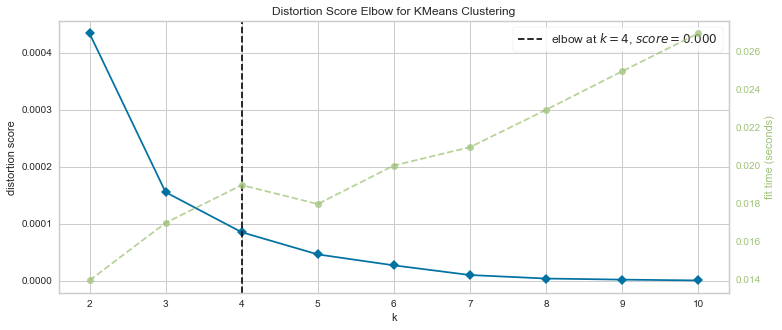

C:\Users\kfuan\Anaconda3\envs\dl_fastai\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [29]:
plt.figure(figsize=(12,5))
kelbow_visualizer(KMeans(), toronto_yoga[['Venue Category_Yoga Studio']])

In [22]:
toronto_yoga = toronto_cat[toronto_cat['Venue Category_Yoga Studio'] > 0][['Venue Category_Yoga Studio']].reset_index()

kmean = KMeans(n_clusters=4)
kmean.fit(toronto_yoga[['Venue Category_Yoga Studio']])
print(set(kmean.labels_))

toronto_yoga['cluster'] = kmean.labels_
toronto_yoga.head()

{0, 1, 2, 3}


,Neighbourhood,Venue Category_Yoga Studio,cluster
0,Central Bay Street,0.015873,3
1,Church and Wellesley,0.025000,2
2,"Little Portugal, Trinity",0.023810,2
3,"North Toronto West, Lawrence Park",0.058824,1
4,"Queen's Park, Ontario Provincial Government",0.032258,0


In [23]:
toronto_cluster = toronto_yoga.merge(toronto_venues, on='Neighbourhood')
print(toronto_cluster.shape)
toronto_cluster.head()

(550, 9)


,Neighbourhood,Venue Category_Yoga Studio,cluster,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Bay Street,0.015873,3,43.657952,-79.387383,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
1,Central Bay Street,0.015873,3,43.657952,-79.387383,Tim Hortons,43.658570,-79.385123,Coffee Shop
2,Central Bay Street,0.015873,3,43.657952,-79.387383,Somethin' 2 Talk About,43.658395,-79.385338,Middle Eastern Restaurant
3,Central Bay Street,0.015873,3,43.657952,-79.387383,Hailed Coffee,43.658833,-79.383684,Coffee Shop
4,Central Bay Street,0.015873,3,43.657952,-79.387383,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop


In [24]:
cluster_0 = toronto_cluster[toronto_cluster['cluster'] == 0]
cluster_1 = toronto_cluster[toronto_cluster['cluster'] == 1]
cluster_2 = toronto_cluster[toronto_cluster['cluster'] == 2]
cluster_3 = toronto_cluster[toronto_cluster['cluster'] == 3]
print(f"cluster 0: {cluster_0.shape}\ncluster1: {cluster_1.shape}\ncluster2: {cluster_2.shape}\ncluster3: {cluster_3.shape}")

cluster 0: (138, 9)
cluster1: (37, 9)
cluster2: (213, 9)
cluster3: (162, 9)


In [33]:
neighbourhood_0 = cluster_0['Neighbourhood'].unique()
neighbourhood_1 = cluster_1['Neighbourhood'].unique()
neighbourhood_2 = cluster_2['Neighbourhood'].unique()
neighbourhood_3 = cluster_3['Neighbourhood'].unique()

neighbour_list = [neighbourhood_0, neighbourhood_1, neighbourhood_2, neighbourhood_3]
for i in range(4):
    print(f"Neighbourhood {i}")
    for neighbour in neighbour_list[i]:
        print(f"\t{neighbour}")
    print("=" *50)

Neighbourhood 0
	Queen's Park, Ontario Provincial Government
	Runnymede, Swansea
	Studio District
	University of Toronto, Harbord
Neighbourhood 1
	North Toronto West, Lawrence Park
	Thorncliffe Park
Neighbourhood 2
	Church and Wellesley
	Little Portugal, Trinity
	Regent Park, Harbourfront
	The Danforth West, Riverdale
Neighbourhood 3
	Central Bay Street
	Stn A PO Boxes


In [65]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(4)
ys = [i+x+(i*x)**2 for i in range(4)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_cluster['Neighborhood Latitude'], 
                                  toronto_cluster['Neighborhood Longitude'], 
                                  toronto_cluster['Neighbourhood'], 
                                  toronto_cluster['cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        fill=True,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters